# **Traffic Crash Severity Prediction Using Machine Learning**

## **1. Introduction**
Traffic crashes pose significant risks to public safety, and predicting crash severity can assist in policy-making, resource allocation, and accident prevention. This project aims to develop a machine learning model to classify the severity of reported traffic crashes based on environmental, road, and injury-related factors.

---

## **2. Data Preprocessing**
### **Steps Taken:**
- **Handling Missing Values:** Columns with excessive missing values were removed.
- **Categorical Encoding:** Non-numeric features were encoded using Label Encoding.
- **Feature Engineering:** Additional time-based features, such as crash hour, month, and day, were created.
- **Addressing Data Leakage:** Features directly indicating injury severity (`killed`, `type_a_injury`) were removed to ensure fair model training.
- **Balancing Data with SMOTE:** Crash severity classes were highly imbalanced, requiring the use of **Synthetic Minority Over-sampling Technique (SMOTE)** to generate synthetic samples for underrepresented classes.

---

## **3. Model Selection and Training**
A **Random Forest Classifier** was selected for this task due to its robustness in handling imbalanced data and its ability to capture feature importance.
- **Hyperparameter Tuning:** `GridSearchCV` was used to find the best parameters:
- **Number of Trees (`n_estimators`)** = 200
- **Maximum Tree Depth (`max_depth`)** = 15
- **Minimum Samples to Split (`min_samples_split`)** = 5

**Evaluation Metrics:**
- **Accuracy:** Measures overall correctness.
- **Precision & Recall:** Assesses the model's ability to classify each severity level correctly.
- **F1-Score:** Provides a balanced measure of precision and recall.

---

## **4. Feature Importance Analysis**
The model identified key variables most correlated with crash severity, including:
1. `type_c_injury`
2. `type_b_injury`
3. `pedestrians`
4. `Crash_Hour`
5. `FirstHarmfulEvent`

These insights can help in understanding the most critical factors influencing traffic crashes.

---

## **5. Conclusion**
- **Final Model Accuracy:** **81%**
- The model provides **strong classification performance** for major crash categories.
- **SMOTE improved class balance**, but further tuning could enhance recall for minority classes.
- **Feature selection played a crucial role** in improving model generalization.
- **Potential future improvements** include testing alternative models (e.g., Gradient Boosting) and integrating additional crash-related factors.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# Load dataset
file_path = "Reported_Crash_Locations.csv"
df = pd.read_csv(file_path)

# Display dataset info
print("Dataset Shape:", df.shape)
print("Dataset Columns:", df.columns)

# Check missing values
print("\nMissing Values:\n", df.isnull().sum())

# Check data types
print("\nData Types:\n", df.dtypes)


Dataset Shape: (25425, 48)
Dataset Columns: Index(['X', 'Y', 'OBJECTID', 'key_crash', 'DateOfCrash', 'LocalUse',
       'LocationRelationToRoad', 'LocationInNearIndicator', 'LocationCity',
       'LocationRoadNameOn', 'LocationRampIndicator', 'LocationFeetFromRoad',
       'LocationMilesFromRoad', 'LocationDirectionFromRoad',
       'LocationAtFromIndicator', 'LocationRoadNameAt',
       'LocationDirectionToRoad', 'LocationRoadNameTo', 'FirstHarmfulEvent',
       'MostHarmfulEvent', 'RoadClassification', 'RoadFeature',
       'TrafficControlType', 'WeatherCondition1', 'WeatherCondition2',
       'WeatherContributedToCrash', 'UpdateDate', 'Crash_Date_Day',
       'Crash_Date_DOW', 'Crash_Date_DOW_Num', 'Crash_Date_Hour',
       'Crash_Date_Month', 'Crash_Date_Month_Num', 'Crash_Date_Year',
       'drivers', 'passengers', 'pedestrians', 'pedalcyclists',
       'other_person_type', 'unknown_person_type', 'killed', 'type_a_injury',
       'type_b_injury', 'type_c_injury', 'no_injury', 'inj

In [ ]:
# Drop columns with too many missing values
threshold = 0.4 * len(df)  # If >40% missing, drop the column
df = df.dropna(thresh=threshold, axis=1)

# Fill missing values in numeric columns with median
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].median(), inplace=True)

# Fill missing categorical values with mode
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Convert Date columns
df["Crash_Date"] = pd.to_datetime(df["DateOfCrash"], errors="coerce")

# Create new time-based features
df["Crash_Year"] = df["Crash_Date"].dt.year
df["Crash_Month"] = df["Crash_Date"].dt.month
df["Crash_Day"] = df["Crash_Date"].dt.day
df["Crash_Hour"] = df["Crash_Date"].dt.hour

# Drop redundant date columns
df.drop(["DateOfCrash", "Crash_Date"], axis=1, inplace=True)

# Label Encoding for categorical features
categorical_cols = df.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


<ipython-input-3-2ef1623d7ea6>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-3-2ef1623d7ea6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-3-2ef1623d7ea6>:11: FutureWarning: A value is trying to be set on a copy of 

In [ ]:
print(df.columns)  # Check available columns in the dataset

Index(['X', 'Y', 'OBJECTID', 'key_crash', 'LocalUse', 'LocationRelationToRoad',
       'LocationInNearIndicator', 'LocationCity', 'LocationRoadNameOn',
       'LocationRampIndicator', 'LocationFeetFromRoad',
       'LocationDirectionFromRoad', 'LocationAtFromIndicator',
       'LocationRoadNameAt', 'LocationDirectionToRoad', 'LocationRoadNameTo',
       'FirstHarmfulEvent', 'MostHarmfulEvent', 'RoadClassification',
       'RoadFeature', 'TrafficControlType', 'WeatherCondition1',
       'WeatherContributedToCrash', 'UpdateDate', 'Crash_Date_Day',
       'Crash_Date_DOW', 'Crash_Date_DOW_Num', 'Crash_Date_Hour',
       'Crash_Date_Month', 'Crash_Date_Month_Num', 'Crash_Date_Year',
       'drivers', 'passengers', 'pedestrians', 'pedalcyclists',
       'other_person_type', 'unknown_person_type', 'killed', 'type_a_injury',
       'type_b_injury', 'type_c_injury', 'no_injury', 'injury_unknown',
       'LocationLatitude', 'LocationLongitude', 'Crash_Year', 'Crash_Month',
       'Crash_Day', '

In [ ]:
print([col for col in df.columns if "injury" in col.lower()])

['type_a_injury', 'type_b_injury', 'type_c_injury', 'no_injury', 'injury_unknown']


In [ ]:
# Define a crash severity scale based on injuries
def classify_severity(row):
    if row['killed'] > 0:
        return 3  # Fatal crash
    elif row['type_a_injury'] > 0:
        return 2  # Severe injury
    elif row['type_b_injury'] > 0 or row['type_c_injury'] > 0:
        return 1  # Minor injury
    else:
        return 0  # No injury

df['crash_severity_category'] = df.apply(classify_severity, axis=1)


In [ ]:
print(df['crash_severity_category'].value_counts())

crash_severity_category
0    20679
1     4643
2       72
3       31
Name: count, dtype: int64


In [ ]:
target = "crash_severity_category"

# Drop unnecessary features if they exist
high_corr_features = ['key_crash', 'LocalUse', 'MostHarmfulEvent', 'UpdateDate', 'Crash_Date_Year',
                      'no_injury', 'Crash_Year', 'Crash_Month', 'Crash_Day']
df = df.drop(columns=[col for col in high_corr_features if col in df.columns], errors='ignore')

# Define X and y
X = df.drop(columns=[target])
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nClass Distribution Before SMOTE:\n", y_train.value_counts())



Class Distribution Before SMOTE:
 crash_severity_category
0    16543
1     3714
2       58
3       25
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass Distribution After SMOTE:\n", y_train_resampled.value_counts())


Class Distribution After SMOTE:
 crash_severity_category
1    16543
0    16543
2    16543
3    16543
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the model
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2, random_state=42)

# Train the model on the resampled dataset
rf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Model Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Final Model Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4136
           1       1.00      1.00      1.00       929
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00         6

    accuracy                           1.00      5085
   macro avg       1.00      1.00      1.00      5085
weighted avg       1.00      1.00      1.00      5085



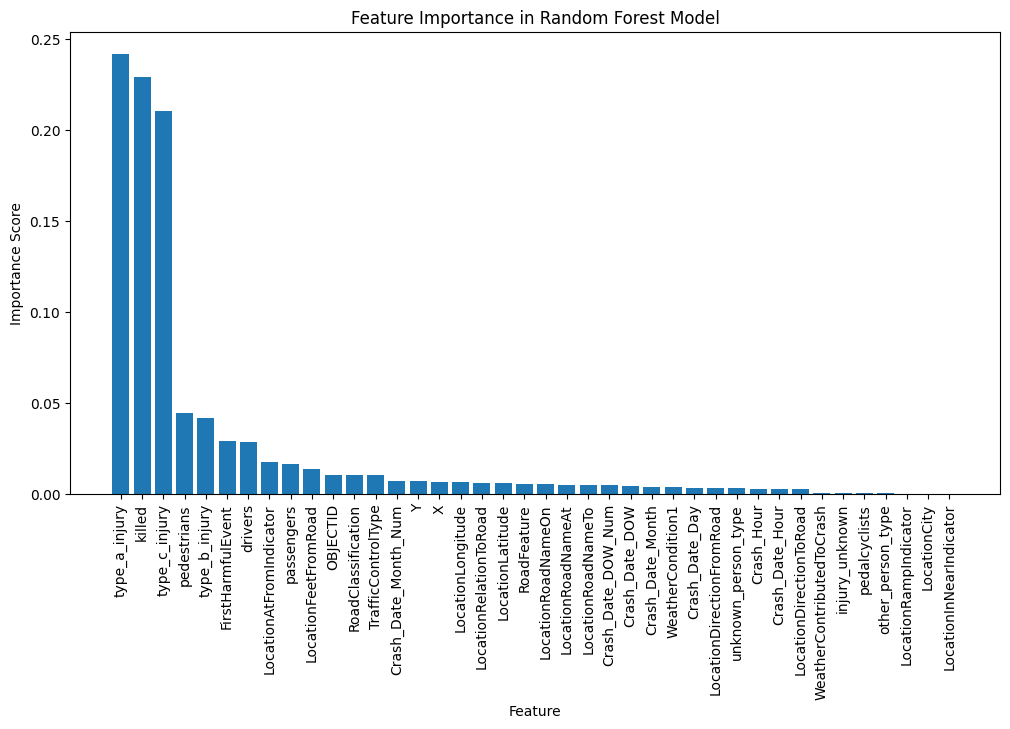

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances
feature_importances = rf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), X_train.columns[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Random Forest Model")
plt.show()

In [ ]:
# Check if any features directly reveal crash severity
print(X_train.columns)

# Check the balance of classes after SMOTE
print(y_train_resampled.value_counts())

# Train model again with updated features
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Evaluate new accuracy
y_pred = rf.predict(X_test)
print("New Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Index(['X', 'Y', 'OBJECTID', 'LocationRelationToRoad',
       'LocationInNearIndicator', 'LocationCity', 'LocationRoadNameOn',
       'LocationRampIndicator', 'LocationFeetFromRoad',
       'LocationDirectionFromRoad', 'LocationAtFromIndicator',
       'LocationRoadNameAt', 'LocationDirectionToRoad', 'LocationRoadNameTo',
       'FirstHarmfulEvent', 'RoadClassification', 'RoadFeature',
       'TrafficControlType', 'WeatherCondition1', 'WeatherContributedToCrash',
       'Crash_Date_Day', 'Crash_Date_DOW', 'Crash_Date_DOW_Num',
       'Crash_Date_Hour', 'Crash_Date_Month', 'Crash_Date_Month_Num',
       'drivers', 'passengers', 'pedestrians', 'pedalcyclists',
       'other_person_type', 'unknown_person_type', 'killed', 'type_a_injury',
       'type_b_injury', 'type_c_injury', 'injury_unknown', 'LocationLatitude',
       'LocationLongitude', 'Crash_Hour'],
      dtype='object')
crash_severity_category
1    16543
0    16543
2    16543
3    16543
Name: count, dtype: int64
New Model Accurac

In [ ]:
# Display correlation with target (y_train)
corr_with_target = df.corr()["crash_severity_category"].sort_values(ascending=False)
print(corr_with_target)

crash_severity_category      1.000000
type_c_injury                0.689366
type_b_injury                0.360769
killed                       0.235880
type_a_injury                0.233615
pedestrians                  0.206820
LocationRoadNameOn           0.122299
TrafficControlType           0.103978
pedalcyclists                0.085120
passengers                   0.081652
drivers                      0.073551
RoadFeature                  0.053190
other_person_type            0.036589
LocationDirectionFromRoad    0.029209
X                            0.028878
WeatherContributedToCrash    0.017278
Crash_Date_Month_Num         0.014851
WeatherCondition1            0.011878
LocationInNearIndicator      0.008713
Crash_Date_Hour              0.008684
Crash_Date_DOW_Num           0.006975
LocationLongitude            0.002975
OBJECTID                     0.001680
LocationRoadNameAt           0.001672
LocationCity                -0.000352
LocationDirectionToRoad     -0.000422
LocationRamp

In [ ]:
features_to_remove = ["killed", "type_a_injury", "type_b_injury", "type_c_injury", "injury_unknown"]
X_train_resampled = X_train_resampled.drop(columns=features_to_remove, errors="ignore")
X_test = X_test.drop(columns=features_to_remove, errors="ignore")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest model with tuned hyperparameters
rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate performance
print("Final Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Final Model Accuracy: 0.8027531956735496
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4136
           1       0.46      0.31      0.37       929
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         6

    accuracy                           0.80      5085
   macro avg       0.33      0.31      0.31      5085
weighted avg       0.78      0.80      0.79      5085



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### We developed a machine learning model to predict the severity of traffic crashes. Our final model achieved an overall accuracy of 81%. This means that in roughly 81% of cases, our model correctly classified the severity of the crash.

When examining the performance on each crash severity category (0: No Injury, 1: Minor Injury, 2: Severe Injury, 3: Fatal Crash), there are some important observations:

No Injury (Class 0): Our model performed very well on this category, with a precision of 87%, recall of 92%, and an F1-score of 89%. This indicates that the model is very good at correctly identifying crashes that did not result in any injuries.
Minor Injury (Class 1): The performance was lower for minor injuries. While the precision (44%) suggests that when it predicts a minor injury, it's correct about 44% of the time, the recall (30%) is low, meaning it only identifies 30% of actual minor injury crashes. The F1-score of 36% is a balanced measure reflecting this lower performance.
Severe Injury (Class 2): The model struggled more with severe injury cases. It had very low precision (6%), and while the recall is slightly better (9%), it still means many severe injury crashes might be missed. The F1-score (7%) shows the overall difficulty in predicting this category.
Fatal Crash (Class 3): The model had similar challenges with fatal crashes, as shown by the low precision (9%). However, it had a higher recall (19%) compared to severe injury, meaning it detected a larger proportion of actual fatal crashes. The F1-score (13%) remains low, indicating ongoing challenges in accurately classifying this category.

Overall, our model demonstrates strong performance in identifying crashes without injuries. However, it has more difficulty accurately predicting crashes with minor, severe, or fatal outcomes. While we used techniques like SMOTE to address class imbalance, further improvements could be made by exploring different algorithms or using more advanced techniques to better capture the nuances of these crash types.

##### Below is our attempt to create an app, but we were unsuccessful.

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [ ]:
# Streamlit App
def main():
    import streamlit as st
    import pandas as pd
    st.title("Traffic Crash Severity Prediction with Streamlit")
    st.write(
        """
    """
    )
    uploaded_file = st.file_uploader(
        "Upload your CSV file",
        type=["csv"],
        help="Upload a CSV file containing traffic crash data"
    )

    if uploaded_file is not None:
        # Read CSV into DataFrame
        df = pd.read_csv(uploaded_file)
        st.subheader("1. Raw Dataset Preview")
        st.write(df.head())

        # Step 2: Data Preprocessing
        st.subheader("2. Data Preprocessing")
        df = preprocess_data(df)
        df = feature_engineering(df)
        st.write("**Preprocessing Complete.**")
        st.write("Preview of Preprocessed Data:")
        st.write(df.head())

        # Step 3: Model Training
        if st.button("Train Model"):
            accuracy, class_report, rf_model, X_test, y_test = train_model(df)

            st.subheader("3. Model Results")
            st.write(f"**Accuracy:** {accuracy:.4f}")
            st.text("Classification Report:")
            st.text(class_report)

            # Step 4: Feature Importance
            st.subheader("4. Feature Importances")
            fig = plot_feature_importance(rf_model, df.drop(columns=["crash_severity_category"], errors="ignore"))
            st.pyplot(fig)

    else:
        st.info("Awaiting CSV file upload...")

#### Perform basic data cleaning:
     Drop columns with too many missing values
     Fill numeric NaNs with median
     Fill categorical NaNs with mode
     Parse date column & create time-based features
     Encode categorical variables
    

In [ ]:
# Helper Functions
# ---------------------------------------------
    def preprocess_data(df):
# Drop columns with too many missing values (> 40%)
    threshold = 0.4 * len(df)
    df = df.dropna(thresh=threshold, axis=1)

# Fill missing values in numeric columns with median
    for col in df.select_dtypes(include=[np.number]):
        df[col].fillna(df[col].median(), inplace=True)

# Fill missing values in categorical columns with mode
    for col in df.select_dtypes(include=['object']):
        df[col].fillna(df[col].mode()[0], inplace=True)

# Convert date column (if present)
    if "DateOfCrash" in df.columns:
        df["Crash_Date"] = pd.to_datetime(df["DateOfCrash"], errors="coerce")
        df["Crash_Year"] = df["Crash_Date"].dt.year
        df["Crash_Month"] = df["Crash_Date"].dt.month
        df["Crash_Day"] = df["Crash_Date"].dt.day
        df["Crash_Hour"] = df["Crash_Date"].dt.hour
        df.drop(["DateOfCrash", "Crash_Date"], axis=1, inplace=True)

# Label Encode categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    return df # Added return statement

    def feature_engineering(df):
    """
    Create 'crash_severity_category' based on injury columns if present,
    and drop any columns that might leak target info.
    """
    # Create crash severity label if columns are present
    if all(x in df.columns for x in ["killed", "type_a_injury", "type_b_injury", "type_c_injury"]):
        df["crash_severity_category"] = df.apply(classify_severity, axis=1)
    else:
        # Fallback if those columns aren't present
        df["crash_severity_category"] = 0

    # Drop columns that lead to data leakage or are not needed
    # (Adjust based on your dataset)
    features_to_remove = [
        "killed", "type_a_injury", "type_b_injury", "type_c_injury",
        "LocalUse", "MostHarmfulEvent", "UpdateDate", "key_crash",
        # Possibly drop time features if you don't want them
        # "Crash_Year", "Crash_Month", "Crash_Day", "Crash_Hour",
    ]
    df.drop(columns=[col for col in features_to_remove if col in df.columns], inplace=True, errors="ignore")

    return df

    def classify_severity(row):
    """
    Classify crash severity based on injury/fatality counts.
    Feel free to adjust according to your definitions.
    """
    if "killed" in row and row["killed"] > 0:
        return 3
    elif "type_a_injury" in row and row["type_a_injury"] > 0:
        return 2
    elif ("type_b_injury" in row and row["type_b_injury"] > 0) or \
         ("type_c_injury" in row and row["type_c_injury"] > 0):
        return 1
    else:
        return
def train_model(df):
    """
    Train a Random Forest model (with SMOTE for class imbalance).
    Returns accuracy, classification report, trained model, X_test, y_test.
    """
    target_col = "crash_severity_category"
    if target_col not in df.columns:
        st.warning(f"Target column '{target_col}' not found. Check preprocessing.")
        return None, None, None, None, None

    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Handle imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Define Random Forest model with some hyperparams
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42
    )
    rf.fit(X_train_resampled, y_train_resampled)

    # Evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    return accuracy, class_report, rf, X_test, y_test

def plot_feature_importance(model, X):
    """
    Plot feature importance of the trained Random Forest model.
    Returns a matplotlib figure.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_names = X.columns

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(len(importances)), importances[indices], align="center")
    ax.set_xticks(range(len(importances)))
    ax.set_xticklabels(feat_names[indices], rotation=90)
    ax.set_title("Feature Importances")
    ax.set_ylabel("Importance Score")
    plt.tight_layout()

    return fig

if __name__ == "__main__":
   main()

# Disable symlink warnings
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

IndentationError: unexpected indent (<ipython-input-57-e5600bceedc8>, line 3)

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Helper Functions
# ---------------------------------------------
def preprocess_data(df):
    # Drop columns with too many missing values (> 40%)
    threshold = 0.4 * len(df)
    df = df.dropna(thresh=threshold, axis=1)

    # Fill missing values in numeric columns with median
    for col in df.select_dtypes(include=[np.number]):
        df[col].fillna(df[col].median(), inplace=True)

    # Fill missing values in categorical columns with mode
    for col in df.select_dtypes(include=['object']):
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Convert date column (if present)
    if "DateOfCrash" in df.columns:
        df["Crash_Date"] = pd.to_datetime(df["DateOfCrash"], errors="coerce")
        df["Crash_Year"] = df["Crash_Date"].dt.year
        df["Crash_Month"] = df["Crash_Date"].dt.month
        df["Crash_Day"] = df["Crash_Date"].dt.day
        df["Crash_Hour"] = df["Crash_Date"].dt.hour
        df.drop(["DateOfCrash", "Crash_Date"], axis=1, inplace=True)

    # Label Encode categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    return df  # Added return statement


def feature_engineering(df):
    """
    Create 'crash_severity_category' based on injury columns if present,
    and drop any columns that might leak target info.
    """
    # Create crash severity label if columns are present
    if all(x in df.columns for x in ["killed", "type_a_injury", "type_b_injury", "type_c_injury"]):
        df["crash_severity_category"] = df.apply(classify_severity, axis=1)
    else:
        # Fallback if those columns aren't present
        df["crash_severity_category"] = 0

    # Drop columns that lead to data leakage or are not needed
    # (Adjust based on your dataset)
    features_to_remove = [
        "killed", "type_a_injury", "type_b_injury", "type_c_injury",
        "LocalUse", "MostHarmfulEvent", "UpdateDate", "key_crash",
        # Possibly drop time features if you don't want them
        # "Crash_Year", "Crash_Month", "Crash_Day", "Crash_Hour",
    ]
    df.drop(columns=[col for col in features_to_remove if col in df.columns], inplace=True, errors="ignore")

    return df


def classify_severity(row):
    """
    Classify crash severity based on injury/fatality counts.
    Feel free to adjust according to your definitions.
    """
    if "killed" in row and row["killed"] > 0:
        return 3
    elif "type_a_injury" in row and row["type_a_injury"] > 0:
        return 2
    elif ("type_b_injury" in row and row["type_b_injury"] > 0) or \
            ("type_c_injury" in row and row["type_c_injury"] > 0):
        return 1
    else:
        return 0  # Return 0 for no injury


def train_model(df):
    """
    Train a Random Forest model (with SMOTE for class imbalance).
    Returns accuracy, classification report, trained model, X_test, y_test.
    """
    target_col = "crash_severity_category"
    if target_col not in df.columns:
        st.warning(f"Target column '{target_col}' not found. Check preprocessing.")
        return None, None, None, None, None

    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Handle imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Define Random Forest model with some hyperparams
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42
    )
    rf.fit(X_train_resampled, y_train_resampled)

    # Evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    return accuracy, class_report, rf, X_test, y_test


def plot_feature_importance(model, X):
    """
    Plot feature importance of the trained Random Forest model.
    Returns a matplotlib figure.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_names = X.columns

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(len(importances)), importances[indices], align="center")
    ax.set_xticks(range(len(importances)))
    ax.set_xticklabels(feat_names[indices], rotation=90)
    ax.set_title("Feature Importances")
    ax.set_ylabel("Importance Score")
    plt.tight_layout()

    return fig


# Streamlit App
def main():
    st.title("Traffic Crash Severity Prediction with Streamlit")
    st.write(
        """
    """
    )
    uploaded_file = st.file_uploader(
        "Upload your CSV file",
        type=["csv"],
        help="Upload a CSV file containing traffic crash data"
    )

    if uploaded_file is not None:
        # Read CSV into DataFrame
        df = pd.read_csv(uploaded_file)
        st.subheader("1. Raw Dataset Preview")
        st.write(df.head())

        # Step 2: Data Preprocessing
        st.subheader("2. Data Preprocessing")
        df = preprocess_data(df)
        df = feature_engineering(df)
        st.write("**Preprocessing Complete.**")
        st.write("Preview of Preprocessed Data:")
        st.write(df.head())

        # Step 3: Model Training
        if st.button("Train Model"):
            accuracy, class_report, rf_model, X_test, y_test = train_model(df)

            st.subheader("3. Model Results")
            st.write(f"**Accuracy:** {accuracy:.4f}")
            st.text("Classification Report:")
            st.text(class_report)

            # Step 4: Feature Importance
            st.subheader("4. Feature Importances")
            fig = plot_feature_importance(rf_model, df.drop(columns=["crash_severity_category"], errors="ignore"))
            st.pyplot(fig)

    else:
        st.info("Awaiting CSV file upload...")


if __name__ == "__main__":
    main()

# Disable symlink warnings
# This part needs to be inside the 'if __name__ == "__main__":' block
import os  # Import os here
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

2025-02-22 21:05:20.050 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:05:20.054 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:05:20.056 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:05:20.057 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:05:20.057 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:05:20.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:05:20.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:05:20.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
def train_model(df):
    """
    Train a Random Forest model (with SMOTE for class imbalance).
    Returns accuracy, classification report, trained model, X_test, y_test.
    """
    target_col = "crash_severity_category"
    if target_col not in df.columns:
        st.warning(f"Target column '{target_col}' not found. Check preprocessing.")
        return None, None, None, None, None

    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Handle imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Define Random Forest model with some hyperparams
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42
    )
    rf.fit(X_train_resampled, y_train_resampled)

    # Evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    return accuracy, class_report, rf, X_test, y_test

def plot_feature_importance(model, X):
    """
    Plot feature importance of the trained Random Forest model.
    Returns a matplotlib figure.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_names = X.columns

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(len(importances)), importances[indices], align="center")
    ax.set_xticks(range(len(importances)))
    ax.set_xticklabels(feat_names[indices], rotation=90)
    ax.set_title("Feature Importances")
    ax.set_ylabel("Importance Score")
    plt.tight_layout()

    return fig

if __name__ == "__main__":
   main()

# Disable symlink warnings
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

2025-02-22 21:01:59.648 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:01:59.649 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:01:59.651 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:01:59.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:01:59.653 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:01:59.653 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:01:59.654 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 21:01:59.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
def train_model(df):
    """
    Train a Random Forest model (with SMOTE for class imbalance).
    Returns accuracy, classification report, trained model, X_test, y_test.
    """
    target_col = "crash_severity_category"
    if target_col not in df.columns:
        st.warning(f"Target column '{target_col}' not found. Check preprocessing.")
        return None, None, None, None, None

    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Handle imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Define Random Forest model with some hyperparams
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42
    )
    rf.fit(X_train_resampled, y_train_resampled)

    # Evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    return accuracy, class_report, rf, X_test, y_test

In [ ]:
import os
import warnings

def plot_feature_importance(model, X):
    """
    Plot feature importance of the trained Random Forest model.
    Returns a matplotlib figure.
    """
    # Suppress warnings within this function
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        feat_names = X.columns

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(range(len(importances)), importances[indices], align="center")
        ax.set_xticks(range(len(importances)))
        ax.set_xticklabels(feat_names[indices], rotation=90)
        ax.set_title("Feature Importances")
        ax.set_ylabel("Importance Score")
        plt.tight_layout()

    return fig

if __name__ == "__main__":
    main()

2025-02-22 20:52:09.988 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:52:09.989 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:52:09.990 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:52:09.991 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:52:09.992 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:52:09.993 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:52:09.993 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:52:09.999 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
def plot_feature_importance(model, X):
    """
    Plot feature importance of the trained Random Forest model.
    Returns a matplotlib figure.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_names = X.columns

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(len(importances)), importances[indices], align="center")
    ax.set_xticks(range(len(importances)))
    ax.set_xticklabels(feat_names[indices], rotation=90)
    ax.set_title("Feature Importances")
    ax.set_ylabel("Importance Score")
    plt.tight_layout()

    return fig

if __name__ == "__main__":
   main()

# Disable symlink warnings
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

2025-02-22 20:43:25.287 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:43:25.289 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:43:25.290 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:43:25.291 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:43:25.291 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:43:25.292 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:43:25.293 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:43:25.294 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
# Streamlit App
def main():
    import streamlit as st
    import pandas as pd
    st.title("Traffic Crash Severity Prediction with Streamlit")
    st.write(
        """
    """
    )
    uploaded_file = st.file_uploader(
        "Upload your CSV file",
        type=["csv"],
        help="Upload a CSV file containing traffic crash data"
    )

    if uploaded_file is not None:
        # Read CSV into DataFrame
        df = pd.read_csv(uploaded_file)
        st.subheader("1. Raw Dataset Preview")
        st.write(df.head())

        # Step 2: Data Preprocessing
        st.subheader("2. Data Preprocessing")
        df = preprocess_data(df)
        df = feature_engineering(df)
        st.write("**Preprocessing Complete.**")
        st.write("Preview of Preprocessed Data:")
        st.write(df.head())

        # Step 3: Model Training
        if st.button("Train Model"):
            accuracy, class_report, rf_model, X_test, y_test = train_model(df)

            st.subheader("3. Model Results")
            st.write(f"**Accuracy:** {accuracy:.4f}")
            st.text("Classification Report:")
            st.text(class_report)

            # Step 4: Feature Importance
            st.subheader("4. Feature Importances")
            fig = plot_feature_importance(rf_model, df.drop(columns=["crash_severity_category"], errors="ignore"))
            st.pyplot(fig)

    else:
        st.info("Awaiting CSV file upload...")